In [59]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sklearn.metrics
import warnings
warnings.filterwarnings("ignore")

In [60]:
data = pd.read_csv('clean_df.csv')
data.head()

,Unnamed: 0,Sample No.,Patient ID,Study ID,Age,Gender,BMI,Symptoms Presented,Symptoms Present?,Fever,Cough,Breathlessness,Travel History,Temp,SPO2,METHYLPREDNISOLONE,Low molecular weight heparin,Hydroxychloroquine,FABIFLU,REMDESIVIR,IVERMECTIN,ANTIBIOTICS,VITAMINs and zinc,Medicine Administered,Contact to NCOVID Patient,Co-morbid Condition,Co-morbidity?,Diabetes,Hypertension,Heart Condition,Hospital stay in days,Respiratory Support,Respiratory rate(breaths per minute),Outcome,O2 supplementation required,Ventilatory support required,qSOFA SCORE,RESPIRATORY FINDINGS,HEMOGLOBIN,TLC COUNT,PLATELET COUNT,RANDOM BLOOD SUGAR,UREA,CREATININE,SODIUM,POTASSIUM,CHLORIDE,TOTAL BILIRUBIN,DIRECT BILIRUBIN,SGOT,SGPT,TOTAL PROTEINS,ALBUMIN,ALKALINE PHOSPHATASE,C-REACTIVE PROTEINS,ECG,CXR,CORADS SCORE ON HRCT,PATIENT CATEGORY,PLASMA THERAPY,Age Above 60?,Temp Groups,CORADS 6
0,0,1013,IGIB1040201013,IGIB1040201013-1,0.551724,1,0.436782,"fever, cough,breathlessness",1,1,1,1,0,0.2,0.833333,1,1,1,1,1,1,1,1,"METHYLPREDNISOLONE, Low molecular weight hepar...",1,no,0,0,0,0,18.0,1,0.3,0,1,0,0,Basal crepitations,0.854839,0.162996,0.030910,0.131285,0.209231,0.000172,0.542857,0.018793,0.862793,0.051282,0.047619,0.171097,0.355532,0.255556,0.300,0.127089,0.152271,sinus rhythm,normal,4.0,5a,No,0,0.2,0.0
1,1,1014,IGIB1040201014,IGIB1040201014-1,0.241379,0,0.804598,asymptomatic,0,0,0,0,0,0.5,0.666667,1,1,1,1,0,1,1,1,"METHYLPREDNISOLONE, Low molecular weight hepar...",1,no,0,0,0,0,NaN,0,0.1,0,0,0,0,Basal crepitations,0.720430,0.072247,0.065827,0.061453,0.051077,0.000121,0.685714,0.011869,0.862793,0.000000,0.000000,0.046414,0.059076,0.333333,0.325,0.172501,0.009346,sinus rhythm,normal,0.0,5b,No,0,0.6,0.0
2,2,1015,IGIB1040201015,IGIB1040201015-1,0.264368,1,0.402299,asymptomatic,0,0,0,0,0,0.4,0.666667,1,1,1,1,0,1,1,1,"METHYLPREDNISOLONE, Low molecular weight hepar...",1,no,0,0,0,0,11.0,0,0.1,0,0,0,0,Basal crepitations,0.854839,0.096035,0.090441,0.078212,0.029538,1.000000,1.000000,0.150346,0.000000,0.128205,0.095238,0.040295,0.048335,0.377778,0.400,0.259224,0.026437,sinus rhythm,normal,0.0,5b,No,0,0.4,0.0
3,3,1016,IGIB1040201016,IGIB1040201016-1,0.781609,1,0.321839,"fever, cough,breathlessness",1,1,1,1,0,0.4,0.666667,1,1,1,1,1,1,1,1,"METHYLPREDNISOLONE, Low molecular weight hepar...",1,no,0,0,0,0,14.0,1,0.6,1,1,1,1,Basal crepitations,0.709677,0.118943,0.092158,0.125698,0.142154,0.000103,0.457143,0.012859,0.830508,0.538462,0.523810,0.124051,0.236842,0.300000,0.275,0.366446,0.443161,sinus rhythm,normal,5.0,4,No,1,0.4,0.0
4,4,1060,IGIB1040201060,IGIB1040201060-1,0.505747,1,1.000000,"fever,cough",1,1,1,0,0,0.8,0.666667,1,1,1,1,1,1,1,1,"METHYLPREDNISOLONE, Low molecular weight hepar...",1,Psychiatric disorder,1,0,0,0,1.0,0,0.3,0,0,0,0,no any,0.736559,0.308370,0.141958,0.050279,0.052308,0.000103,0.000000,0.008902,0.733656,1.000000,0.952381,0.093671,0.277658,0.255556,0.125,0.546200,0.430297,sinus rhythm,normal,5.0,4,No,0,0.8,0.0


In [61]:
data.drop(columns=['Unnamed: 0'], inplace = True)

## Model

In [62]:
def model_perf(x,y,model):
    cm = metrics.confusion_matrix(y, model.predict(x))
    plt.figure
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.savefig('covidseverity.png')
    accuracy = model.score(x,y)
    precision,recall,f1,support = sklearn.metrics.precision_recall_fscore_support(y, model.predict(x),average='binary')
    print("Accuracy Score = ",accuracy)
    print("Precision Score = ",precision)    
    print("Recall Score = ",recall)    
    print("F1 Score = ",f1)

In [63]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [64]:
def visualize(x,y, model):
    
        cm = metrics.confusion_matrix(y, model.predict(x))
        plt.figure
        sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
        plt.ylabel('Actual label');
        plt.xlabel('Predicted label');
        plt.savefig('covidseverity.png')
        
        
def ttmodel(X, Y, lm, n):
    
        train_accuracy = [0]*n
        train_precision = [0]*n
        train_recall = [0]*n
        train_f1 = [0]*n

        test_accuracy = [0]*n
        test_precision = [0]*n
        test_recall = [0]*n
        test_f1 = [0]*n
        
        for i in range(n):
            x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

            lm.fit(x_train,y_train)

            train_accuracy[i] = lm.score(x_train,y_train)
            train_precision[i], train_recall[i], train_f1[i], s = sklearn.metrics.precision_recall_fscore_support(y_train, lm.predict(x_train), average='weighted')

            test_accuracy[i] = lm.score(x_test,y_test)
            test_precision[i], test_recall[i], test_f1[i], s = sklearn.metrics.precision_recall_fscore_support(y_test, lm.predict(x_test), average='weighted')

        print("Average training statistics over",n,"runs of the NN model - ")
        print("Accuracy Score = ", sum(train_accuracy)/n)
        print("Precision Score = ", sum(train_precision)/n)    
        print("Recall Score = ", sum(train_recall)/n)   
        print("F1 Score = ", sum(train_f1)/n) 

        print()
        
        print("Average testing statistics over",n,"runs of the NN model - ")
        print("Accuracy Score = ", sum(test_accuracy)/n)
        print("Precision Score = ", sum(test_precision)/n)    
        print("Recall Score = ", sum(test_recall)/n)   
        print("F1 Score = ", sum(test_f1)/n) 
        
        visualize(x_test, y_test, lm)
        
        
def cvmodel(X, Y, lm, cv):
    
        from sklearn.model_selection import cross_validate
        scoring = ['f1','roc_auc']
        scores = cross_validate(lm, X, Y, cv=cv, scoring = scoring, return_train_score=True)
        
        for k,v in scores.items():
            ans = [min(v),sum(v)/len(v),max(v)]
            print(k,"=",ans)
            print()

## Initial Factors + Symptoms and Comorbidities + Blood

In [65]:
X = data[['Age Above 60?','Gender','Temp Groups','Respiratory rate(breaths per minute)','Symptoms Present?','Co-morbidity?','Cough','Breathlessness','Hypertension','C-REACTIVE PROTEINS','UREA']]
Y = data['Outcome']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state=0)

In [66]:
model = MLPClassifier()
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

model, pred = algorithm_pipeline(Xtrain, Xtest, ytrain, ytest, model, param_grid, 
                                 cv=5)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   42.6s finished


0.3014683911842017
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}


Average training statistics over 100 runs of the NN model - 
Accuracy Score =  0.9888549618320617
Precision Score =  0.9890871533084626
Recall Score =  0.9888549618320617
F1 Score =  0.9888844745505196

Average testing statistics over 100 runs of the NN model - 
Accuracy Score =  0.889772727272727
Precision Score =  0.8965298169317153
Recall Score =  0.889772727272727
F1 Score =  0.8882822275191125


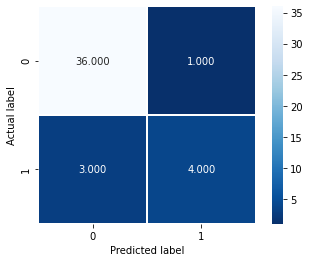

In [69]:
model = MLPClassifier(hidden_layer_sizes = (50, 50, 50), activation = 'relu', learning_rate = 'adaptive', solver = 'adam', alpha = 0.0001)
ttmodel(X, Y, model, 100)

In [70]:
cvmodel(X,Y,model,7)

fit_time = [0.3981952667236328, 0.42027214595249723, 0.4663259983062744]

score_time = [0.006016969680786133, 0.006412608282906669, 0.007277488708496094]

test_f1 = [0.4, 0.6331065759637189, 0.888888888888889]

train_f1 = [0.9047619047619048, 0.9553348779627039, 1.0]

test_roc_auc = [0.803030303030303, 0.9001236858379718, 1.0]

train_roc_auc = [0.9944629014396457, 0.9971258199165176, 1.0]

